<a href="https://colab.research.google.com/github/HarrisonCaetanoCandido/Simulac-ao-e-An-alise-de-Modelos-de-Difus-ao-de-Contaminantes-em-Agua/blob/main/Entrega2_PCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega 2 - Projeto PCD

Membro 1: Camila Barretto Lins Paes
Membro 2: Harrison Caetano Candido
Membro 3: Laura Maria Cunha Lisboa

email: camila.paes@unifesp.br, h.candido20@unifesp.br, lisboa01@unifesp.br

## Instalações

In [ ]:
ls

cad4u/                    cuda_output_step_700.txt      paralelo_output_step_400.txt
code.cu                   cuda_output_step_800.txt      paralelo_output_step_500.txt
code.out*                 cuda_output_step_900.txt      paralelo_output_step_600.txt
cuda_output_final.txt     main*                         paralelo_output_step_700.txt
cuda_output_step_0.txt    main.c                        paralelo_output_step_800.txt
cuda_output_step_100.txt  main.cu                       paralelo_output_step_900.txt
cuda_output_step_200.txt  paralelo_output_final.txt     plugin.py
cuda_output_step_300.txt  paralelo_output_step_0.txt    processador.txt
cuda_output_step_400.txt  paralelo_output_step_100.txt  __pycache__/
cuda_output_step_500.txt  paralelo_output_step_200.txt  sample_data/
cuda_output_step_600.txt  paralelo_output_step_300.txt


In [ ]:
!apt-get update
!apt-get install -y gcc

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 384 kB in 1s (298 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

In [ ]:
!apt-get install libgomp1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgomp1 is already the newest version (12.3.0-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [ ]:
!more /proc/cpuinfo &> processador.txt
!more processador.txt | grep model

model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


## Código

In [ ]:
%%writefile main.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define N 600         // Dimensão da grade
#define TIME_STEPS 1000 // Número de passos de tempo
#define D 0.1        // Coeficiente de difusão aumentado
#define DT 0.01        // Passo de tempo aumentado
#define DX 1.0        // Distância entre pontos na grade
#define NUM_THREADS 1

void initialize_grid(double grid[N][N]) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            grid[i][j] = 0.0;
        }
    }
    int center = N / 2;
    grid[center][center] = 100.0; // Alta concentração no centro
}

void save_grid(double grid[N][N], const char* filename) {
    FILE* file = fopen(filename, "w");
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            fprintf(file, "%.2f ", grid[i][j]);
        }
        fprintf(file, "\n");
    }
    fclose(file);
}

int main() {
    double grid[N][N], new_grid[N][N];
    omp_set_num_threads(NUM_THREADS);
    initialize_grid(grid);

    double alpha = D * DT / (DX * DX);
    if (alpha > 0.25) {
        printf("Erro: Fator alpha instável (%.2f).\n", alpha);
        return -1;
    }

    double start_time = omp_get_wtime();

    for (int t = 0; t < TIME_STEPS; t++) {
        #pragma omp parallel for collapse(2)
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                new_grid[i][j] = grid[i][j] + alpha * (
                    grid[i+1][j] + grid[i-1][j] +
                    grid[i][j+1] + grid[i][j-1] -
                    4 * grid[i][j]
                );
            }
        }

        #pragma omp parallel for collapse(2)
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                grid[i][j] = new_grid[i][j];
            }
        }

        // Condições de contorno: bordas fixas
        #pragma omp parallel for
        for (int i = 0; i < N; i++) {
            grid[i][0] = grid[i][N-1] = 0.0;
            grid[0][i] = grid[N-1][i] = 0.0;
        }

        if (t % 100 == 0) { // Salvar a cada 100 iterações
            char filename[50];
            sprintf(filename, "paralelo_output_step_%d.txt", t);
            save_grid(grid, filename);
        }
    }

    double end_time = omp_get_wtime();
    printf("Simulação finalizada em %.2f segundos.\n", end_time - start_time);
    save_grid(grid, "paralelo_output_final.txt");
    return 0;
}


Overwriting main.c


In [ ]:
%%shell
gcc -fopenmp main.c -o main
./main

Simulação finalizada em 5.75 segundos.


#### Gráfico

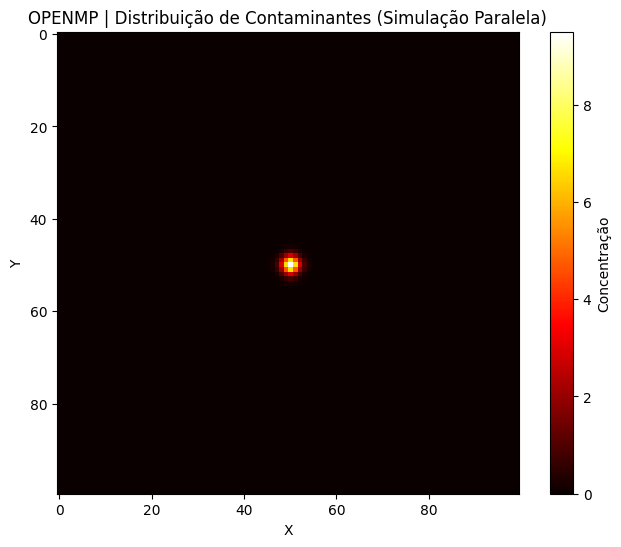

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('paralelo_output_final.txt')

data = data[250:-250, 250:-250]

plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.colorbar(label='Concentração')
plt.title('OPENMP | Distribuição de Contaminantes (Simulação Paralela)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


## **Configurando o Google Lab (colab)**
Executar o comando abaixo para permitir a execução de códigos de maneira mais simplificada.

In [ ]:
!pip install git+https://github.com/lesc-ufv/cad4u.git &> /dev/null
!git clone https://github.com/lesc-ufv/cad4u &> /dev/null
%load_ext plugin

The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


In [ ]:
!nvidia-smi

Fri Dec  6 01:15:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

4. Implementação com CUDA (Simulação em GPU)
Implementar a simulação em CUDA, onde cada célula da grade é processada por uma thread independente na GPU, utilizando um
esquema de diferenças finitas para calcular o laplaciano de (C).
A execução em GPU permite simular uma grade maior e observar o ganho de desempenho com CUDA.
**Entrega 2:** demonstrar o código em CUDA e apresentar avaliação de desempenho com relação às versões anteriores.

In [ ]:
%%gpu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

#define N 600         // Dimensão da grade
#define TIME_STEPS 1000 // Número de passos de tempo
#define D 0.1         // Coeficiente de difusão
#define DT 0.01       // Passo de tempo
#define DX 1.0        // Distância entre pontos na grade
#define THREADS_PER_BLOCK 32

__global__ void update_grid(double* d_grid, double* d_new_grid, double alpha, int n) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (i > 0 && i < n - 1 && j > 0 && j < n - 1) {
        d_new_grid[i * n + j] = d_grid[i * n + j] + alpha * (
            d_grid[(i + 1) * n + j] + d_grid[(i - 1) * n + j] +
            d_grid[i * n + j + 1] + d_grid[i * n + j - 1] -
            4 * d_grid[i * n + j]
        );
    }
}

__global__ void apply_boundaries(double* d_grid, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n) {
        d_grid[idx] = 0.0;            // Linha superior
        d_grid[(n - 1) * n + idx] = 0.0; // Linha inferior
        d_grid[idx * n] = 0.0;            // Coluna esquerda
        d_grid[idx * n + n - 1] = 0.0;    // Coluna direita
    }
}

void initialize_grid(double* grid, int n) {
    for (int i = 0; i < n * n; i++) {
        grid[i] = 0.0;
    }
    int center = n / 2;
    grid[center * n + center] = 100.0; // Alta concentração no centro
}

void save_grid(double* grid, const char* filename, int n) {
    FILE* file = fopen(filename, "w");
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            fprintf(file, "%.2f ", grid[i * n + j]);
        }
        fprintf(file, "\n");
    }
    fclose(file);
}

int main() {
    double* grid = (double*)malloc(N * N * sizeof(double));
    double* d_grid, *d_new_grid;

    cudaMalloc(&d_grid, N * N * sizeof(double));
    cudaMalloc(&d_new_grid, N * N * sizeof(double));

    initialize_grid(grid, N);

    cudaMemcpy(d_grid, grid, N * N * sizeof(double), cudaMemcpyHostToDevice);

    double alpha = D * DT / (DX * DX);
    if (alpha > 0.25) {
        printf("Erro: Fator alpha instável (%.2f).\n", alpha);
        free(grid);
        cudaFree(d_grid);
        cudaFree(d_new_grid);
        return -1;
    }

    dim3 threadsPerBlock(THREADS_PER_BLOCK, THREADS_PER_BLOCK);
    dim3 blocksPerGrid((N + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK,
                       (N + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK);

    double start_time = clock();

    for (int t = 0; t < TIME_STEPS; t++) {
        update_grid<<<blocksPerGrid, threadsPerBlock>>>(d_grid, d_new_grid, alpha, N);
        cudaMemcpy(d_grid, d_new_grid, N * N * sizeof(double), cudaMemcpyDeviceToDevice);
        apply_boundaries<<<(N + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK, THREADS_PER_BLOCK>>>(d_grid, N);

        if (t % 100 == 0) { // Salvar a cada 100 iterações
            cudaMemcpy(grid, d_grid, N * N * sizeof(double), cudaMemcpyDeviceToHost);
            char filename[50];
            sprintf(filename, "cuda_output_step_%d.txt", t);
            save_grid(grid, filename, N);
        }
    }

    double end_time = clock();
    printf("Simulação finalizada em %.2f segundos.\n", (end_time - start_time) / CLOCKS_PER_SEC);

    cudaMemcpy(grid, d_grid, N * N * sizeof(double), cudaMemcpyDeviceToHost);
    save_grid(grid, "cuda_output_final.txt", N);

    free(grid);
    cudaFree(d_grid);
    cudaFree(d_new_grid);
    return 0;
}

Simulação finalizada em 1.30 segundos.



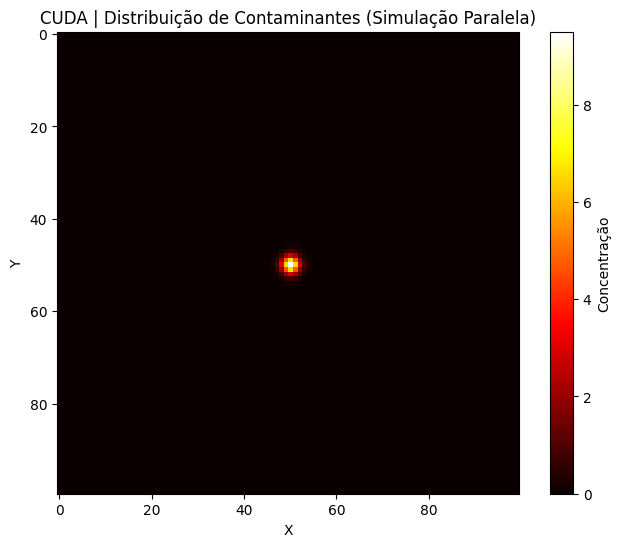

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('cuda_output_final.txt')

data = data[250:-250, 250:-250]

plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.colorbar(label='Concentração')
plt.title('CUDA | Distribuição de Contaminantes (Simulação Paralela)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
